# Эксперимент №1
https://archive.ics.uci.edu/ml/datasets/Maternal+Health+Risk+Data+Set

In [1]:
import sys
import os

sys.path.append('..')
folder_path = os.path.abspath(os.path.join(os.getcwd(), "../../evaluate"))
sys.path.append(folder_path)

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tools import deletion_features
from tools import balancing
from tools import encoder
from tools import scaling
from Alg_CatBoost import CatBoostRegressor_fill 
from Alg_DecisionTree import DecisionTreeRegressor_fill
from Alg_Interpolate import interpolate_fill
from Alg_KNNImputer import KNNImputer_fill
from Alg_LinearRegression import LinearRegression_fill
from Alg_max import max_fill
from Alg_mean import mean_fill 
from Alg_median import median_fill
from Alg_min import min_fill
from Alg_RandomForestRegressor import RandomForestRegressor_fill
from Alg_SVR import SVR_fill
from Alg_XGBRegressor import XGBRegressor_fill
import results_metrics
import results_metrics_visualization

In [3]:
#считываем тренировочные данные
df = pd.read_csv('Maternal Health Risk Data Set.csv')

df.shape

(1014, 7)

# 1. Исследуем данные

In [4]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [5]:
#проверим данные на типы
df.dtypes

Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object

In [6]:
#проверим на пропуски
df.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [7]:
df.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')

In [8]:
print(len(df.columns))

7


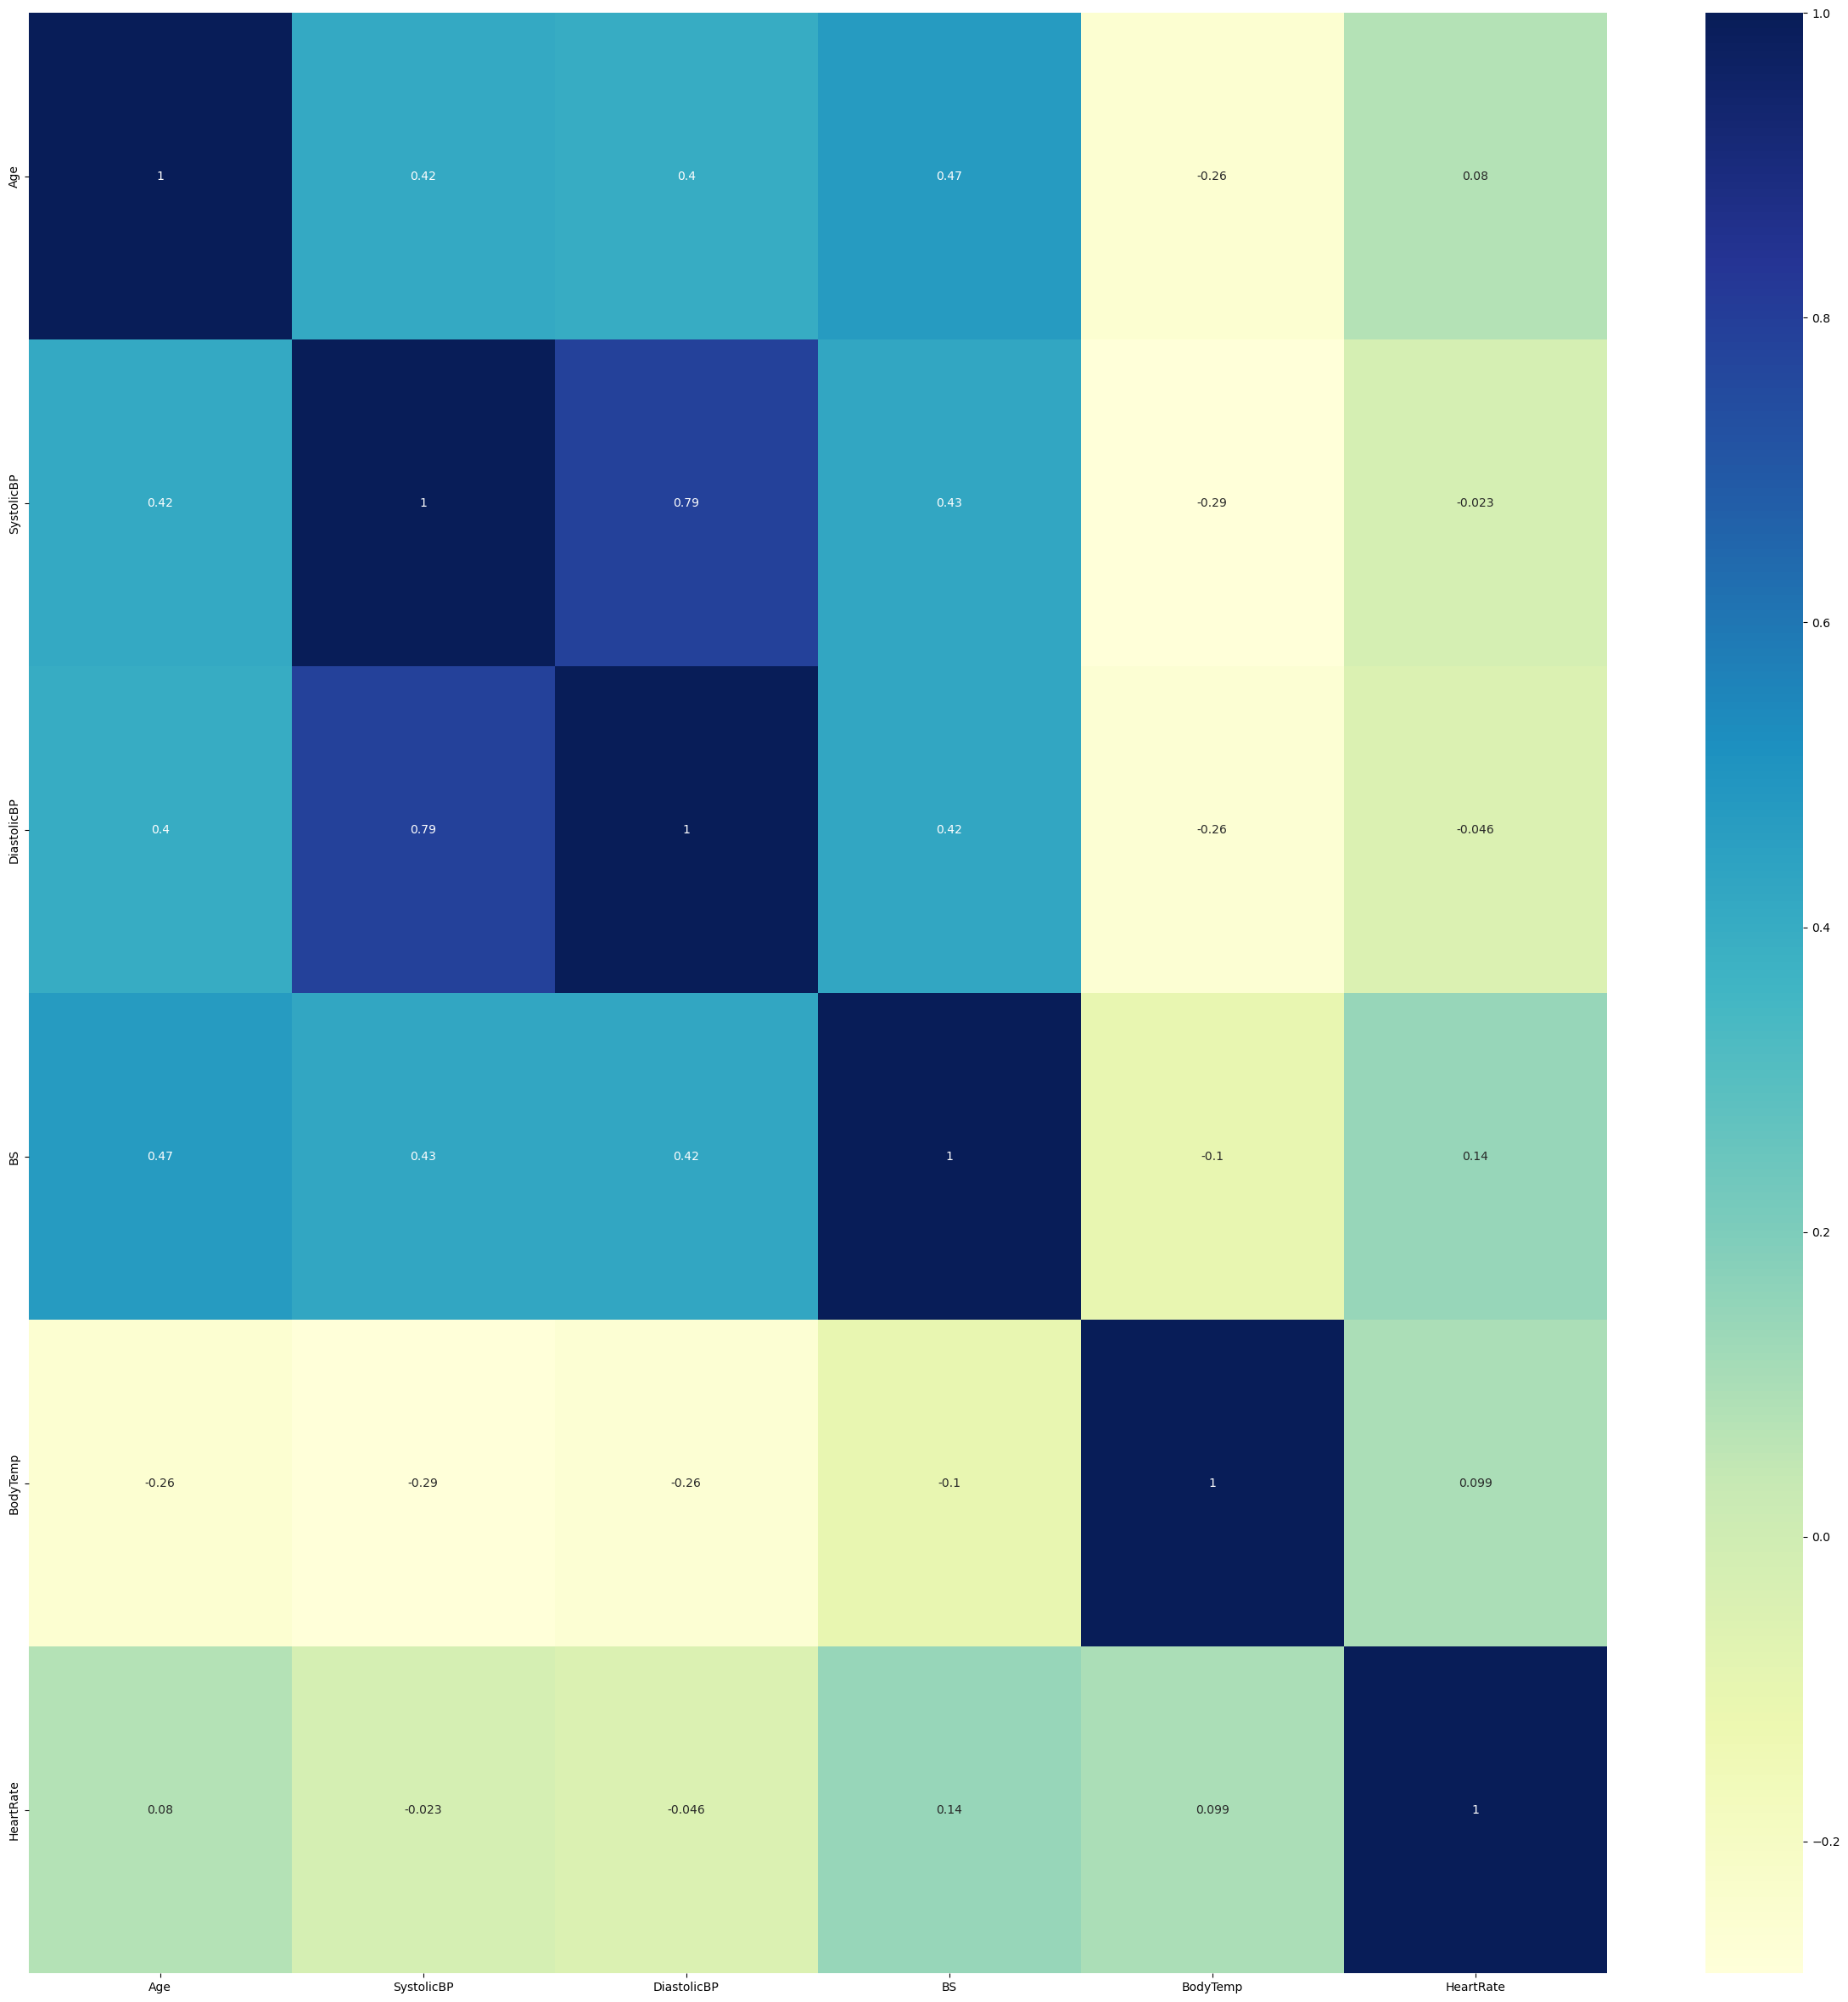

In [9]:
#построим корреляционную матрицу
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),cmap='YlGnBu', annot=True)

plt.savefig('train_corr')

# 2. Произведем предобработку данных

# 2.1. Балансировка данных

Проверим на сбалансированность данных. Проверять будет по признаку RiskLevel  - прогнозируемый уровень интенсивности риска во время беременности с учетом предыдущего атрибута.

In [10]:
df['RiskLevel'].value_counts()

low risk     406
mid risk     336
high risk    272
Name: RiskLevel, dtype: int64

Данные не сбалансированны, реализуем балансировку используя методы oversampling SMOTE

In [11]:
df = balancing.data_balancing(df, 'RiskLevel')

In [12]:
df['RiskLevel'].value_counts()

high risk    406
low risk     406
mid risk     406
Name: RiskLevel, dtype: int64

In [13]:
df.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

# 2.2. Кодирование данных

In [14]:
data = encoder.data_encoding(df)

C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
data.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel_high risk', 'RiskLevel_low risk', 'RiskLevel_mid risk'],
      dtype='object')

In [16]:
print(len(data.columns))

9


In [17]:
data.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
BodyTemp               0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

In [18]:
data.dtypes

Age                      int64
SystolicBP               int64
DiastolicBP              int64
BS                     float64
BodyTemp               float64
HeartRate                int64
RiskLevel_high risk    float64
RiskLevel_low risk     float64
RiskLevel_mid risk     float64
dtype: object

# 2.3. Устранение дубликатов

In [19]:
#проверяем наличие дубликатов и удаляем их
data.drop_duplicates(inplace=True)

# 2.4. Работа с аномалиями

Проверяем на аномалии и устраняем их

Информация об атрибутах:
Age: Any ages in years when a women during pregnant.
SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
BS: Blood glucose levels is in terms of a molar concentration, mmol/L.
HeartRate: A normal resting heart rate in beats per minute.
Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.

In [20]:
#построим boxplot для каждого признака, чтобы посмотреть на наличие аномалий

<AxesSubplot:>

<Figure size 500x500 with 0 Axes>

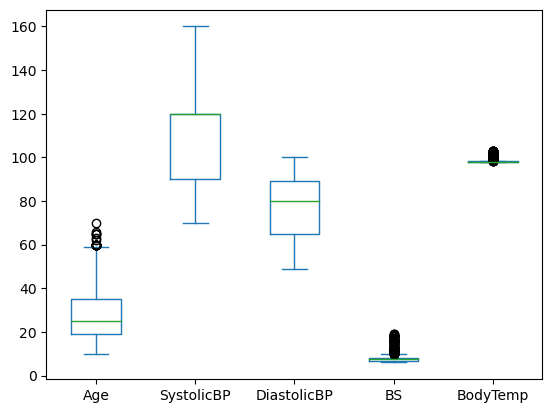

In [21]:
plt.figure(figsize=(5,5))

data[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp']].plot(kind='box')

<AxesSubplot:>

<Figure size 500x500 with 0 Axes>

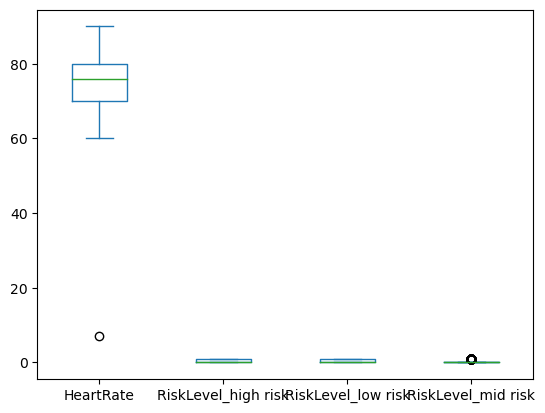

In [22]:
plt.figure(figsize=(5,5))

data[['HeartRate','RiskLevel_high risk', 'RiskLevel_low risk', 'RiskLevel_mid risk']].plot(kind='box')

Аномалии присутсвуют в таких признаках, как: 'Age', 'BS', 'BodyTemp', 'HeartRate'
посмотрим отдельно по каждому признаку с аномалиями значения его квартилей и выведем строки с непосредственно выбросами

In [23]:
#Смотрим на выбросы по признаку Age
Q1 =  data.Age.quantile(0.25)
Q3 = data.Age.quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(IQR)
print(Q3)

data[(data.Age < Q1-1.5*IQR ) | (data.Age > Q3+1.5*IQR)]

19.0
16.0
35.0


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel_high risk,RiskLevel_low risk,RiskLevel_mid risk
36,60,120,80,6.100000,98.0,75,0.0,1.0,0.0
54,60,90,65,7.000000,98.0,77,0.0,1.0,0.0
91,60,120,85,15.000000,98.0,60,0.0,0.0,1.0
99,60,90,65,6.800000,98.0,77,0.0,0.0,1.0
114,63,140,90,15.000000,98.0,90,1.0,0.0,0.0
181,60,120,85,15.000000,98.0,60,1.0,0.0,0.0
280,60,120,80,7.700000,98.0,75,0.0,1.0,0.0
309,60,90,65,6.900000,98.0,77,0.0,1.0,0.0
313,62,120,80,6.900000,98.0,66,0.0,1.0,0.0
322,65,90,60,6.900000,98.0,70,0.0,1.0,0.0


In [24]:
len(data[(data.Age < Q1-1.5*IQR ) | (data.Age > Q3+1.5*IQR)])

24

По аризнаку Age получилось 23 выброса. Возраст в приведенных выбросах колеблется от 60 до 70 лет. Исходя из описания данных:
Age - возраст беременных женщин. Если брать статистику, то репродуктивном период у жензин длится примерно с 15 до 60 лет.
После этого возраста беременность практически невозможна. Поэтому удалим выбросы по этому признаку, так как сокрее всего 
это ошибка в данных.

In [25]:
data = data[(data.Age >= Q1-1.5*IQR ) & (data.Age <= Q3+1.5*IQR)]

In [26]:
#Смотрим на выбросы по признаку BS
Q1 =  data.BS.quantile(0.25)
Q3 = data.BS.quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(IQR)
print(Q3)

data[(data.BS < Q1-1.5*IQR ) | (data.BS > Q3+1.5*IQR)]

6.9
1.1718339384920746
8.071833938492075


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel_high risk,RiskLevel_low risk,RiskLevel_mid risk
0,25,130,80,15.000000,98.000000,86,1.0,0.0,0.0
1,35,140,90,13.000000,98.000000,70,1.0,0.0,0.0
7,35,85,60,11.000000,102.000000,86,1.0,0.0,0.0
9,42,130,80,18.000000,98.000000,70,1.0,0.0,0.0
14,48,120,80,11.000000,98.000000,88,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
1130,17,110,75,12.635521,101.000000,76,1.0,0.0,0.0
1133,42,140,100,16.846267,98.192289,90,1.0,0.0,0.0
1139,45,125,80,16.508360,98.000000,70,1.0,0.0,0.0
1142,52,120,80,14.124971,98.000000,70,1.0,0.0,0.0


In [27]:
len(data[(data.BS < Q1-1.5*IQR ) | (data.BS > Q3+1.5*IQR)])

103

По признаку BS было вявлено 65 выбросов. Данный признак говорит об уровне глюкозы в крови ммоль/л. Уроень глюкозы в выбросах варьируется от 11 до 19 ммоль/л. Такой уровень глюкозы может видетельстовать о наличии сахарного диабета у пциента. Эти данные вполне могут иметь место быть, поэтому данные выбросы необходимо будет учесть и их нельзя заменять или удалять

In [28]:
Q1 =  data.BodyTemp.quantile(0.25)
Q3 = data.BodyTemp.quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(IQR)
print(Q3)

data[(data.BodyTemp < Q1-1.5*IQR ) | (data.BodyTemp > Q3+1.5*IQR)]

98.0
0.5064108924566142
98.50641089245661


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel_high risk,RiskLevel_low risk,RiskLevel_mid risk
2,29,90,70,8.000000,100.000000,80,1.0,0.0,0.0
7,35,85,60,11.000000,102.000000,86,1.0,0.0,0.0
13,20,120,75,7.010000,100.000000,70,0.0,0.0,1.0
18,30,120,80,6.900000,101.000000,76,0.0,0.0,1.0
35,12,95,60,6.100000,102.000000,60,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
1147,17,90,63,7.932720,101.070821,69,1.0,0.0,0.0
1154,30,120,80,7.388386,101.000000,76,0.0,0.0,1.0
1183,13,90,65,7.883331,101.000000,80,0.0,0.0,1.0
1186,18,120,80,7.623378,102.000000,76,0.0,0.0,1.0


In [29]:
len(data[(data.BodyTemp < Q1-1.5*IQR ) | (data.BodyTemp > Q3+1.5*IQR)])

114

In [30]:
print(data.BodyTemp.mean())
print(data.BodyTemp.median())

98.76967521263583
98.0


В признаке BodyTemp обнаружено около половины выбросов. BodyTemp - признак отвечающий за температуру тела. Среднее арифметическое по признаку равно 98.7, а медианное 98. Вероятно при занесении данных в датасет была произведена ошибка на всех пациентах. Поэтому есть смысл удалить этот столбец, чтобы он не влиял в дальнейшем на результаты

In [31]:
data = data.drop(columns=['BodyTemp'])

In [32]:
Q1 =  data.HeartRate.quantile(0.25)
Q3 = data.HeartRate.quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(IQR)
print(Q3)

data[(data.HeartRate < Q1-1.5*IQR ) | (data.HeartRate > Q3+1.5*IQR)]

70.0
10.0
80.0


,Age,SystolicBP,DiastolicBP,BS,HeartRate,RiskLevel_high risk,RiskLevel_low risk,RiskLevel_mid risk
499,16,120,75,7.9,7,0.0,1.0,0.0


In [33]:
print(data.HeartRate.mean())
print(data.HeartRate.median())

74.1
76.0


По признаку HeartRate есть один выброс. HeartRate  - признак, который отвечает за нормальную частоту сердечных сокращений в состоянии покоя в ударах в минуту. Исходя из статистики средняя частота сердечных сокращений взрослого человека составляет от 60 до 80 ударов в минуту. В выбросе показатель равен 7, что явно является ошибкой и данный выброс можно не учитывать 

In [34]:
data = data[(data.HeartRate >= Q1-1.5*IQR ) & (data.HeartRate <= Q3+1.5*IQR)]

# 2.5. Масштабирование данных

Произведем масштабирование данных

In [35]:
data = scaling.data_scaling(data)

In [36]:
data

,Age,SystolicBP,DiastolicBP,BS,HeartRate,RiskLevel_high risk,RiskLevel_low risk,RiskLevel_mid risk
0,-0.263791,1.024291,0.282378,2.111253,1.551932,1.402039,-0.857780,-0.560289
1,0.567463,1.575122,0.999023,1.446324,-0.557618,1.402039,-0.857780,-0.560289
2,0.068711,-1.179033,-0.434268,-0.215996,0.760851,1.402039,-0.857780,-0.560289
3,0.151836,1.575122,0.640701,-0.548460,-0.557618,1.402039,-0.857780,-0.560289
4,0.567463,0.473460,-1.150914,-0.847678,0.233463,-0.713247,1.165801,-0.560289
...,...,...,...,...,...,...,...,...
1207,-1.011919,-1.179033,-0.864255,-0.581707,0.233463,-0.713247,-0.857780,1.784792
1212,-0.430042,-0.628202,0.640701,-0.448249,-1.085006,-0.713247,-0.857780,1.784792
1213,-0.097540,0.473460,0.999023,-0.554732,-0.557618,-0.713247,-0.857780,1.784792
1214,-1.011919,-0.958700,-0.649262,-0.581707,0.365310,-0.713247,-0.857780,1.784792


# 3. Работаем с пропусками

data - после предобработки данных был получен эталонный датасет с которым будет происходить сравнение по метрикам

In [37]:
data.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

# 3.1. Искусственно создаем пропуски

In [38]:
# искусственно создаем пропуски в данных, которые впоследствии будем заполнять
# выбираем случайный признак
df_copy = data.copy()
random_feature = np.random.choice(df_copy.columns)

In [39]:
df1 = deletion_features.make_missing_value(df_copy, 0.1, random_feature)

<AxesSubplot:>

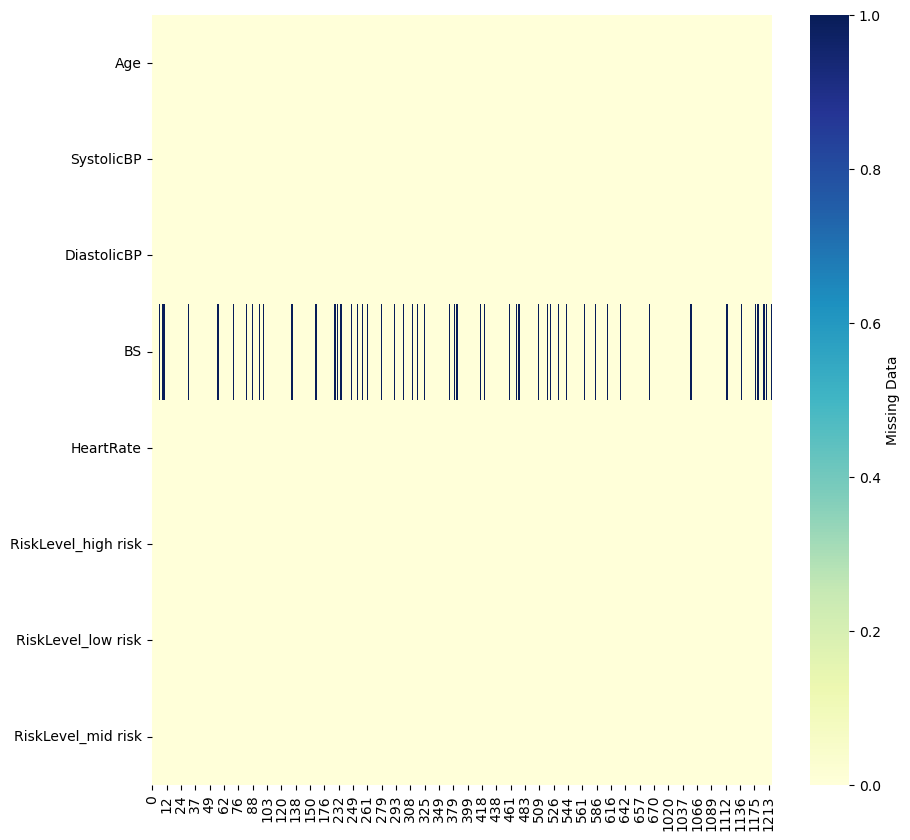

In [40]:
#визуализируем наличие пропусков
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(df1).isna().transpose(), cmap = "YlGnBu", cbar_kws={'label':'Missing Data'})

In [41]:
df1.isna().sum()

Age                     0
SystolicBP              0
DiastolicBP             0
BS                     51
HeartRate               0
RiskLevel_high risk     0
RiskLevel_low risk      0
RiskLevel_mid risk      0
dtype: int64

создадим датасет с 15% пропусков для сравнения результатов заполнения

In [42]:
df15 = deletion_features.make_missing_value(df_copy, 0.15, random_feature)
df15.isna().sum()

Age                     0
SystolicBP              0
DiastolicBP             0
BS                     77
HeartRate               0
RiskLevel_high risk     0
RiskLevel_low risk      0
RiskLevel_mid risk      0
dtype: int64

In [43]:
df20 = deletion_features.make_missing_value(df_copy, 0.2, random_feature)
df20.isna().sum()

Age                      0
SystolicBP               0
DiastolicBP              0
BS                     103
HeartRate                0
RiskLevel_high risk      0
RiskLevel_low risk       0
RiskLevel_mid risk       0
dtype: int64

# 3.2. Заполняем пропуски

#1. Заполним пропуски средним арифметическим значением по признаку

In [44]:
df_mean_fill = mean_fill.mean_fill(df1)

In [45]:
df_mean_fill.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

#2. Заполним пропуски медианным значением по признаку

In [46]:
df_median_fill = median_fill.median_fill(df1)
df_median_fill.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

#3. Заполним пропуски минимальным значением по признаку

In [47]:
df_min_fill = min_fill.min_fill(df1)
df_min_fill.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

#4. Заполним пропуски максимальным значением по признаку

In [48]:
df_max_fill = df_min_fill = max_fill.max_fill(df1)
df_max_fill.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

#5. Заполним пропуски используя интерполяцию

интерполяция даже при 10% пропусков по признакам не в состоянии восстановить все значения (напишем свой алгоритм заполнения на основе интерполяции)

In [49]:
#df_interpolate_fill = interpolate_fill.interpolate_fill(df1)
#df_interpolate_fill.isna().sum()

#6. Заполним пропуски используя линейную регрессию

In [50]:
df_LinearReg_fill = LinearRegression_fill.linreg_imputer(df1)
df_LinearReg_fill.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

#7 Заполним пропуски используя KNNImputer

KNNImputer при 15% пропусков по признаку не смог восстановить все значения (напишем свой алгоритм заполнения на основе KNN)

In [51]:
df_KNNImputer_fill = KNNImputer_fill.KNNImputer_fill(df1)
df_KNNImputer_fill.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

#8 Заполним пропуски используя дерево решений

In [52]:
df_DecisionTree_fill = DecisionTreeRegressor_fill.DecisionTree_imputer(df1)
df_DecisionTree_fill.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

#9 Заполним пропуски используя случайный лес

In [53]:
df_RandomForest_fill = RandomForestRegressor_fill.RandomForest_imputer(df1)
df_RandomForest_fill.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

#10 Заполним пропуски используя SVM

In [54]:
df_SVM_fill = SVR_fill.SVM_imputer(df1)
df_SVM_fill.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

#11 Заполним пропуски используя градиентный бустинг - XGboost

In [55]:
df_XGBRegressor_fill = XGBRegressor_fill.XGBRegressor_imputer(df1)
df_XGBRegressor_fill.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

#12 Заполним пропуски используя градиентный бустинг - CatBoost

In [56]:
df_CatBoostRegressor_fill = CatBoostRegressor_fill.CatBoostRegressor_imputer(df1)
df_CatBoostRegressor_fill.isna().sum()

Learning rate set to 0.035645
0:	learn: 0.9729784	total: 138ms	remaining: 2m 17s
1:	learn: 0.9554367	total: 141ms	remaining: 1m 10s
2:	learn: 0.9396320	total: 143ms	remaining: 47.6s
3:	learn: 0.9258563	total: 146ms	remaining: 36.3s
4:	learn: 0.9109054	total: 149ms	remaining: 29.6s
5:	learn: 0.8959005	total: 151ms	remaining: 25s
6:	learn: 0.8823161	total: 154ms	remaining: 21.8s
7:	learn: 0.8684899	total: 156ms	remaining: 19.4s
8:	learn: 0.8553898	total: 159ms	remaining: 17.5s
9:	learn: 0.8435931	total: 161ms	remaining: 16s
10:	learn: 0.8316381	total: 164ms	remaining: 14.7s
11:	learn: 0.8197668	total: 166ms	remaining: 13.7s
12:	learn: 0.8084337	total: 169ms	remaining: 12.8s
13:	learn: 0.7963201	total: 172ms	remaining: 12.1s
14:	learn: 0.7857491	total: 174ms	remaining: 11.4s
15:	learn: 0.7756350	total: 175ms	remaining: 10.8s
16:	learn: 0.7665192	total: 178ms	remaining: 10.3s
17:	learn: 0.7568000	total: 180ms	remaining: 9.84s
18:	learn: 0.7477704	total: 182ms	remaining: 9.42s
19:	learn: 0.

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

In [57]:
data.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

# 4. Формируем результаты эксперимента

In [58]:
all_methods = [df_mean_fill, df_median_fill, df_min_fill, df_max_fill, df_LinearReg_fill, df_KNNImputer_fill, df_DecisionTree_fill, df_RandomForest_fill, df_SVM_fill, df_XGBRegressor_fill, df_CatBoostRegressor_fill]
df1_result = results_metrics.generate_results_metrics(data, all_methods)
df1_result

,Mean_absolute_error,Mean_squared_error,r2_score
Mean,0.019291,0.026592,0.966222
Median,0.014895,0.030229,0.962703
Min,0.085348,0.320227,0.880113
Max,0.085348,0.320227,0.880113
LinearRegression,0.014552,0.016606,0.980859
KNNImputer,0.009232,0.009350,0.989652
DecisionTree,0.008976,0.010953,0.988903
RandomForest,0.009390,0.008875,0.990356
SVR,0.010999,0.013671,0.984050
XGBRegressor,0.009648,0.009837,0.989610


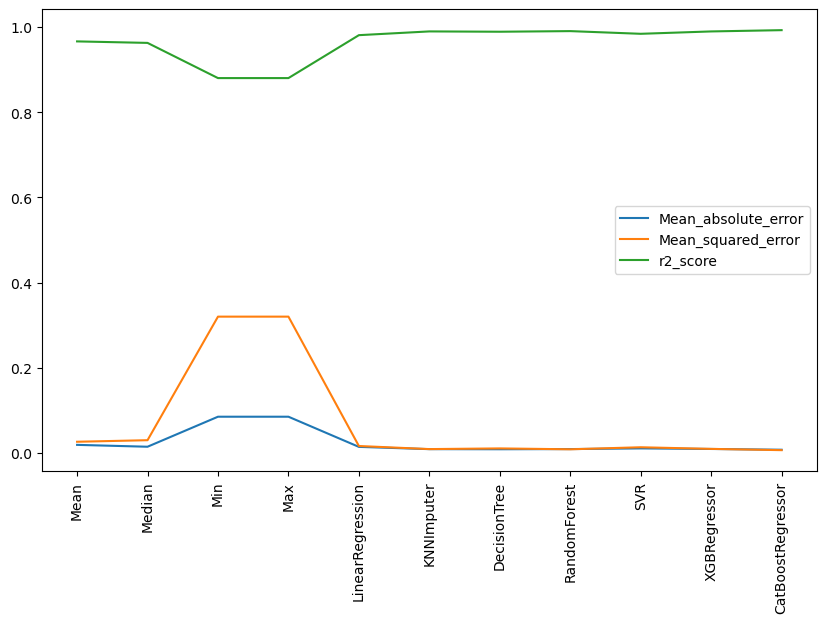

In [59]:
results_metrics_visualization.visualization_results_metrics(df1_result)

In [60]:
all_methods = [mean_fill.mean_fill(df15), median_fill.median_fill(df15), min_fill.min_fill(df15), max_fill.max_fill(df15),
              LinearRegression_fill.linreg_imputer(df15), KNNImputer_fill.KNNImputer_fill(df15), DecisionTreeRegressor_fill.DecisionTree_imputer(df15),
              RandomForestRegressor_fill.RandomForest_imputer(df15), SVR_fill.SVM_imputer(df15), XGBRegressor_fill.XGBRegressor_imputer(df15), CatBoostRegressor_fill.CatBoostRegressor_imputer(df15)]
df15_result = results_metrics.generate_results_metrics(data, all_methods)
df15_result

Learning rate set to 0.035645
0:	learn: 0.9729784	total: 1.01ms	remaining: 1.01s
1:	learn: 0.9554367	total: 1.91ms	remaining: 952ms
2:	learn: 0.9396320	total: 2.85ms	remaining: 947ms
3:	learn: 0.9258563	total: 4.32ms	remaining: 1.07s
4:	learn: 0.9109054	total: 5.28ms	remaining: 1.05s
5:	learn: 0.8959005	total: 6.21ms	remaining: 1.03s
6:	learn: 0.8823161	total: 7.14ms	remaining: 1.01s
7:	learn: 0.8684899	total: 8.05ms	remaining: 998ms
8:	learn: 0.8553898	total: 8.95ms	remaining: 986ms
9:	learn: 0.8435931	total: 9.86ms	remaining: 976ms
10:	learn: 0.8316381	total: 10.8ms	remaining: 971ms
11:	learn: 0.8197668	total: 11.8ms	remaining: 968ms
12:	learn: 0.8084337	total: 12.7ms	remaining: 968ms
13:	learn: 0.7963201	total: 13.7ms	remaining: 967ms
14:	learn: 0.7857491	total: 14.5ms	remaining: 950ms
15:	learn: 0.7756350	total: 15.2ms	remaining: 937ms
16:	learn: 0.7665192	total: 16.2ms	remaining: 937ms
17:	learn: 0.7568000	total: 17.2ms	remaining: 939ms
18:	learn: 0.7477704	total: 18.1ms	remaining

,Mean_absolute_error,Mean_squared_error,r2_score
Mean,0.019291,0.026592,0.966222
Median,0.014895,0.030229,0.962703
Min,0.021870,0.045872,0.949628
Max,0.085348,0.320227,0.880113
LinearRegression,0.014552,0.016606,0.980859
KNNImputer,0.009232,0.009350,0.989652
DecisionTree,0.009886,0.012798,0.987428
RandomForest,0.009544,0.008758,0.990425
SVR,0.010999,0.013671,0.984050
XGBRegressor,0.009648,0.009837,0.989610


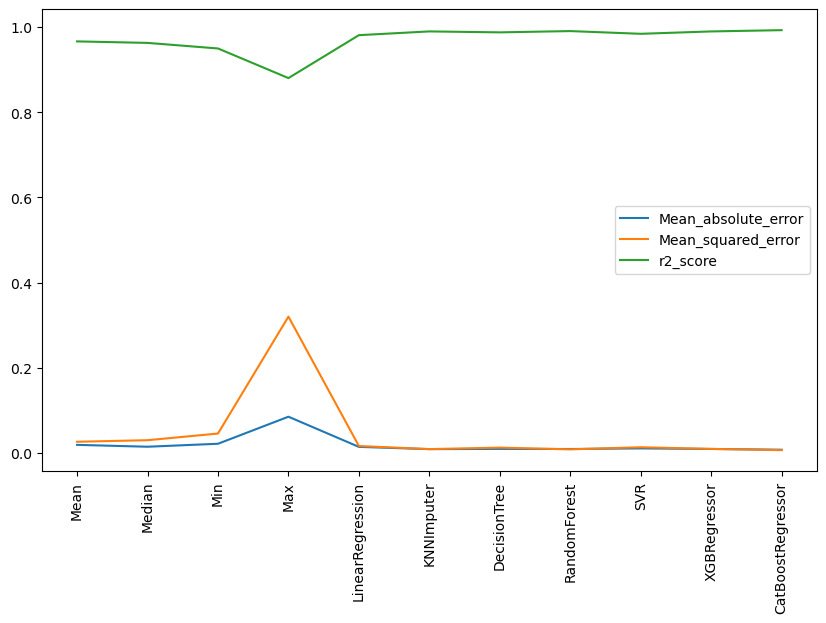

In [61]:
results_metrics_visualization.visualization_results_metrics(df15_result)

In [62]:
all_methods = [mean_fill.mean_fill(df20), median_fill.median_fill(df20), min_fill.min_fill(df20), max_fill.max_fill(df20),
              LinearRegression_fill.linreg_imputer(df20), KNNImputer_fill.KNNImputer_fill(df20), DecisionTreeRegressor_fill.DecisionTree_imputer(df20),
              RandomForestRegressor_fill.RandomForest_imputer(df20), SVR_fill.SVM_imputer(df20), XGBRegressor_fill.XGBRegressor_imputer(df20), CatBoostRegressor_fill.CatBoostRegressor_imputer(df20)]
df20_result = results_metrics.generate_results_metrics(data, all_methods)
df20_result

Learning rate set to 0.035645
0:	learn: 0.9729784	total: 1.02ms	remaining: 1.02s
1:	learn: 0.9554367	total: 1.96ms	remaining: 979ms
2:	learn: 0.9396320	total: 2.85ms	remaining: 946ms
3:	learn: 0.9258563	total: 3.68ms	remaining: 917ms
4:	learn: 0.9109054	total: 4.56ms	remaining: 907ms
5:	learn: 0.8959005	total: 5.5ms	remaining: 911ms
6:	learn: 0.8823161	total: 6.43ms	remaining: 913ms
7:	learn: 0.8684899	total: 7.34ms	remaining: 911ms
8:	learn: 0.8553898	total: 8.23ms	remaining: 906ms
9:	learn: 0.8435931	total: 9.18ms	remaining: 909ms
10:	learn: 0.8316381	total: 10.1ms	remaining: 908ms
11:	learn: 0.8197668	total: 11ms	remaining: 903ms
12:	learn: 0.8084337	total: 11.9ms	remaining: 901ms
13:	learn: 0.7963201	total: 12.8ms	remaining: 900ms
14:	learn: 0.7857491	total: 13.6ms	remaining: 890ms
15:	learn: 0.7756350	total: 14.3ms	remaining: 879ms
16:	learn: 0.7665192	total: 15.2ms	remaining: 880ms
17:	learn: 0.7568000	total: 16.1ms	remaining: 877ms
18:	learn: 0.7477704	total: 16.8ms	remaining: 8

,Mean_absolute_error,Mean_squared_error,r2_score
Mean,0.019291,0.026592,0.966222
Median,0.014895,0.030229,0.962703
Min,0.021870,0.045872,0.949628
Max,0.085348,0.320227,0.880113
LinearRegression,0.014552,0.016606,0.980859
KNNImputer,0.009232,0.009350,0.989652
DecisionTree,0.009532,0.011833,0.988079
RandomForest,0.009408,0.008553,0.990634
SVR,0.010999,0.013671,0.984050
XGBRegressor,0.009648,0.009837,0.989610


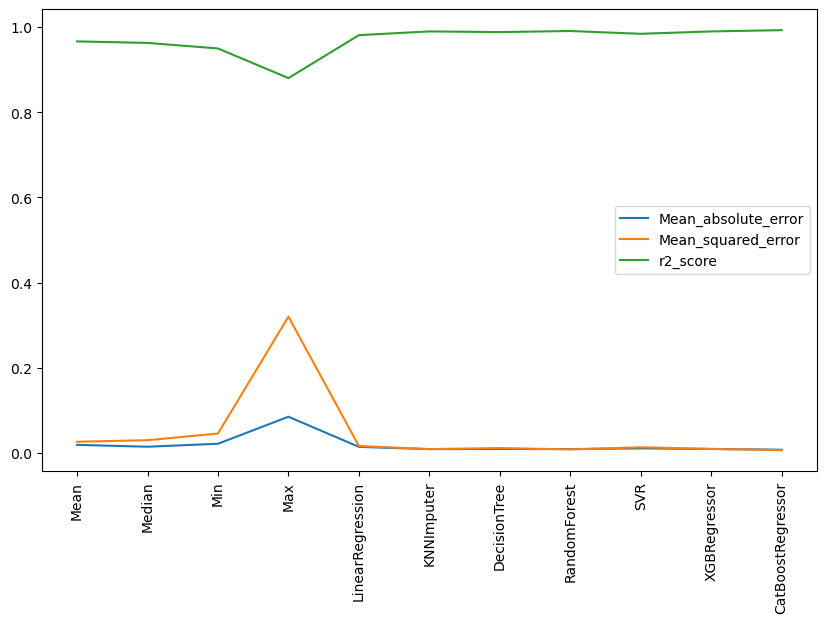

In [63]:
results_metrics_visualization.visualization_results_metrics(df20_result)